In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2025-12-24 10:44:22.999442: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-24 10:44:23.215183: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-24 10:44:24.177882: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-24 10:44:24.181383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-24 10:44:26.556080: W tensorflow/compiler/tf2t

In [2]:
# create dataset of values between -1 and 1 for 2D goal space
intervals = 51
au = 0.8
seed = 0

xx = np.linspace(-au, au, intervals)
yy = np.linspace(-au, au, intervals)
xx, yy = np.meshgrid(xx, yy)
traj = np.vstack([xx.ravel(), yy.ravel()]).T
print(traj.shape)

ncues = 12
holes = np.linspace(-au+0.2, au-0.2, 7)
holoc_all = np.array([[y, x] for x in holes[::-1] for y in holes])

np.random.seed(seed)
reward_locs = np.random.choice(len(holoc_all), ncues, replace=False)
targets = holoc_all[reward_locs]
memory = np.concatenate([targets, np.ones((ncues,1))], axis=1)
print(memory.shape)


(2601, 2)
(12, 3)


In [3]:
class MotorControllerWithActivations(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        self.h1 = base_model.h1
        self.h2 = base_model.h2
        self.action = base_model.action

    def call(self, x):
        h1_out = self.h1(x)
        h2_out = self.h2(h1_out)
        a_out  = self.action(h2_out)
        return a_out, h1_out, h2_out

In [4]:
# load the motor controller
nhid = 128
L = 2
N = 128*L

raw_model = tf.keras.models.load_model('../motor_controller/mc_2h128_linear_30mb_31sp_0.6oe_20e_2022-10-08')
model = MotorControllerWithActivations(raw_model)

print(raw_model.summary())

Model: "motor_controller"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  multiple                  768       
                                                                 
 h2 (Dense)                  multiple                  16512     
                                                                 
 action (Dense)              multiple                  5160      
                                                                 
Total params: 22,440
Trainable params: 22,440
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
c=0
np.concatenate([np.tile(memory[c], (traj.shape[0], 1)), traj], axis=1).shape

(2601, 5)

In [6]:
# get neural responses
hs = np.zeros([ncues, traj.shape[0], N])

for c in range(ncues):

    x = np.concatenate([np.tile(memory[c], (traj.shape[0], 1)), traj], axis=1)

    # get hidden activations of tensorflow model
    # hidden_activations = nmc.layers[0](tf.convert_to_tensor(x[t], dtype=tf.float32))
    action_out, h1_act, h2_act = model(x)
    h = tf.concat([h1_act, h2_act], axis=1)
    hs[c, :, :] = h.numpy()

In [7]:
# targets: shape (ncues, 2), target_coords for each cue
# traj: shape (ntime, 2)

# Precompute for efficiency
goal_distances = np.zeros((ncues, traj.shape[0]))
goal_angles = np.zeros((ncues, traj.shape[0]))

for c, goal in enumerate(targets):
    agent_pos = traj
    dist = np.linalg.norm(agent_pos - goal, axis=1)
    # angle: agent to goal
    dx, dy = goal[0] - agent_pos[:,0], goal[1] - agent_pos[:,1]
    ang = np.degrees(np.arctan2(dy, dx))  # [-180, 180]
    goal_distances[c, :] = dist
    goal_angles[c, :] = ang
print(goal_distances.shape)
print(goal_angles.shape)

(12, 2601)
(12, 2601)


In [8]:
from scipy.stats import spearmanr
from scipy.stats import kurtosis

distance_corrs = np.zeros((N, ncues))
angle_tunings = np.zeros((N, ncues))

n_bins = 51  # For plotting

for c in range(ncues):
    for n in range(N):
        firing = hs[c, :, n]
        
        # Distance corr: negative Spearman (monotonic, firing^ goes as distance v)
        dist = goal_distances[c, :]
        r, _ = spearmanr(-dist, firing)  # fire more as distance decreases
        distance_corrs[n, c] = r
        
        # Angle tuning: tuning curve sharpness as "peakiness"/kurtosis
        angle = goal_angles[c, :]
        bins = np.linspace(-180, 180, n_bins)
        digitized = np.digitize(angle, bins)
        means = np.array([firing[digitized == i].mean() if np.any(digitized==i) else 0 for i in range(1, len(bins))])
        angle_tunings[n, c] = kurtosis(means)  # high value = peaky tuning

/n/home04/mgkumar/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


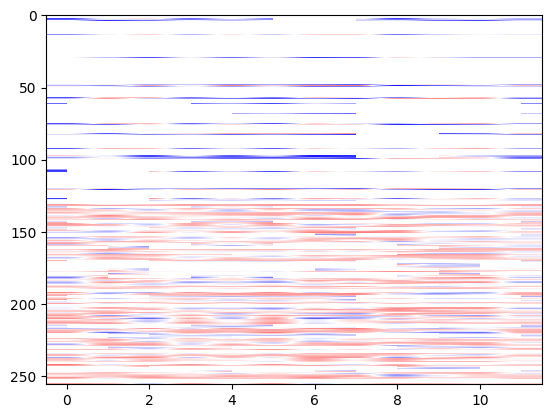

In [9]:
plt.imshow(distance_corrs, aspect='auto', cmap='bwr', vmin=-1, vmax=1)

In [10]:
topk = 3
def top_k_valid_indices(metric, k):
    good = ~np.isnan(metric)
    sorted_idx = np.argsort(metric[good])[-k:][::-1]
    return np.where(good)[0][sorted_idx]

def top_k_strict_indices(metrics, k):
    """
    metrics: array of shape (N, M) [N neurons, M cues or measurements]
    k: number of top neurons to return

    Returns indices of top-k neurons (by mean), where all values are finite (no nan at all).
    """
    no_nan_mask = np.all(~np.isnan(metrics), axis=1)
    means = np.mean(metrics[no_nan_mask], axis=1)
    vars = np.var(metrics[no_nan_mask], axis=1) +1e-6
    # means /= vars
    # Get indices of top-k among valid (no-nan) rows
    sorted_idx = np.argsort(means)[-k:][::-1]
    # Map back to original indices
    return np.where(no_nan_mask)[0][sorted_idx]


# Distance cells: high mean monotonicity across cues
# distance_cell_idxs = top_k_valid_indices(np.nanmean(distance_corrs, axis=1), 3)

# # Angle cells: high mean tuning peakiness (could also screen for entropy/unimodal peak etc)
# angle_cell_idxs = top_k_valid_indices(np.nanmean(angle_tunings, axis=1), 3)

distance_cell_idxs = top_k_strict_indices(distance_corrs, topk)
angle_cell_idxs = top_k_strict_indices(angle_tunings, topk)

print('Top distance cell idxs:', distance_cell_idxs)
print('Top angle cell idxs:', angle_cell_idxs)

Top distance cell idxs: [162 132 166]
Top angle cell idxs: [196 189 226]


In [11]:
metrics = distance_corrs
no_nan_mask = np.all(~np.isnan(metrics), axis=1)
means = np.mean(metrics[no_nan_mask], axis=1)
sorted_idx = np.argsort(means)[-topk:][::-1]
cellidx = np.where(no_nan_mask)[0][sorted_idx]



In [12]:
np.argsort(means)

array([  7,   2,  31,  36,  13,  20,  39,   0,  15,   6,  37,  32,  24,
        30,  21,   8,  19,   3,  12,  27,  10,   4,  35,  29,   9,  23,
        11,  38,  16,  18,  40,  26,  28,   5, 102,  45,  17,  34,   1,
        25,  22,  14,  65,  61,  44,  33,  99,  82, 110,  74,  52,  79,
       113,  95,  91, 101,  60,  55,  83,  59, 129,  87,  56,  62, 107,
        90,  78,  64,  81, 104,  70,  50, 111,  93,  68,  75, 103,  71,
        43, 100,  57, 120, 130,  67, 124, 106, 119,  85,  88,  96, 118,
        63, 125, 122,  53, 126,  47,  48, 114, 117,  80,  76, 116, 133,
        97,  77, 123,  86, 131,  72,  46,  73, 134,  49, 121,  54, 112,
        92,  84,  58, 115,  94, 128,  98, 109, 105,  41,  51,  89, 108,
       132, 127,  69,  42,  66])

In [13]:
import matplotlib.pyplot as plt

def plot_distance_and_angle_cells(hs, goal_distances, goal_angles, cell_idxs, cell_type='Distance', bins=30):
    fig, axs = plt.subplots(len(cell_idxs), ncues, figsize=(ncues*1.5, len(cell_idxs)+1))
    for row, n in enumerate(cell_idxs):
        for c in range(ncues):
            firing = hs[c, :, n]
            ax = axs[row, c]
            if cell_type == 'Distance':
                dist = goal_distances[c, :]
                bin_edges = np.linspace(dist.min(), dist.max(), bins+1)
                inds = np.digitize(dist, bin_edges)
                means = np.array([firing[inds == i].mean() if np.any(inds==i) else np.nan for i in range(1, len(bin_edges))])
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                ax.plot(bin_centers, means, color='C0')
                ax.set_xlabel('Goal Dist.' if row == len(cell_idxs)-1 else '')
                ax.set_ylabel(f'Cell {n}' if c == 0 else '')
                ax.set_xlim([0,2])
                if row == len(cell_idxs)-1:
                    ax.set_xticks([0, 1, 2])
                else:
                    ax.set_xticks([])
                    
            else:  # Angle
                ang = goal_angles[c, :]
                bin_edges = np.linspace(-180, 180, bins+1)
                inds = np.digitize(ang, bin_edges)
                means = np.array([firing[inds == i].mean() if np.any(inds==i) else np.nan for i in range(1, len(bin_edges))])
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                ax.plot(bin_centers, means, color='orange')
                ax.set_xlabel('Goal Angle' if row == len(cell_idxs)-1 else '', fontsize=8)
                ax.set_ylabel(f'Cell {n}' if c == 0 else '', fontsize=8)
                ax.set_xlim([-180, 180])
                if row == len(cell_idxs)-1:
                    ax.set_xticks([-180, 0, 180])
                else:
                    ax.set_xticks([])
                # print(n, c, bin_centers[means.argmax()])
            # ax.set_xticks([])
            # ax.set_yticks([])
            if row == 0:
                ax.set_title(f'Cue {c}\nGoal\n{targets[c]}', fontsize=8)
    fig.suptitle(f"{cell_type} Cells", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(f'./analysis_figs/{cell_type}_navigate.pdf',bbox_inches='tight')
    plt.show()



In [19]:


def plot_distance_cells(hs, goal_distances, cell_idxs, cell_type='Distance', bins=30):
    fig, axs = plt.subplots(len(cell_idxs), ncues, figsize=(ncues*1.5, len(cell_idxs)+1), sharex=True, sharey=False)
    for row, n in enumerate(cell_idxs):
        for c in range(ncues):
            firing = hs[c, :, n]
            ax = axs[row, c]

            dist = goal_distances[c, :]
            bin_edges = np.linspace(dist.min(), dist.max(), bins+1)
            inds = np.digitize(dist, bin_edges)
            means = np.array([firing[inds == i].mean() if np.any(inds==i) else np.nan for i in range(1, len(bin_edges))])
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            ax.plot(bin_centers, means, color='C0')
            ax.set_xlabel('Goal Dist.' if row == len(cell_idxs)-1 else '')
            ax.set_ylabel(f'Cell {n}' if c == 0 else '')
            ax.set_xlim([-0.1,2])
            if row == len(cell_idxs)-1:
                ax.set_xticks([0, 1, 2])
            else:
                ax.set_xticks([])
                
            if row == 0:
                ax.set_title(f'Cue {c}\n{targets[c]}')
    fig.suptitle(f"{cell_type} Cells")
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(f'./analysis_figs/{cell_type}_navigate.pdf',bbox_inches='tight')
    fig.savefig(f'./analysis_figs/{cell_type}_navigate.svg',bbox_inches='tight')
    plt.show()


def plot_angle_cells(hs, goal_angles, cell_idxs, cell_type='Distance', bins=30):
    fig, axs = plt.subplots(len(cell_idxs), ncues, figsize=(ncues*1.5, len(cell_idxs)+1), sharex=True, sharey=False)
    for row, n in enumerate(cell_idxs):
        for c in range(ncues):
            firing = hs[c, :, n]
            ax = axs[row, c]

            ang = goal_angles[c, :]
            bin_edges = np.linspace(-180, 180, bins+1)
            inds = np.digitize(ang, bin_edges)
            means = np.array([firing[inds == i].mean() if np.any(inds==i) else np.nan for i in range(1, len(bin_edges))])
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            ax.plot(bin_centers, means, color='orange')
            ax.set_xlabel('Goal Angle' if row == len(cell_idxs)-1 else '')
            ax.set_ylabel(f'Cell {n}' if c == 0 else '')
            ax.set_xlim([-180, 180])
            if row == len(cell_idxs)-1:
                ax.set_xticks([-180, 0, 180])
            else:
                ax.set_xticks([])
            # print(n, c, bin_centers[means.argmax()])
            # ax.set_xticks([])
            # ax.set_yticks([])
            if row == 0:
                ax.set_title(f'Cue {c}\n{targets[c]}')
    fig.suptitle(f"{cell_type} Cells")
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(f'./analysis_figs/{cell_type}_navigate.pdf',bbox_inches='tight')
    fig.savefig(f'./analysis_figs/{cell_type}_navigate.svg',bbox_inches='tight')
    plt.show()



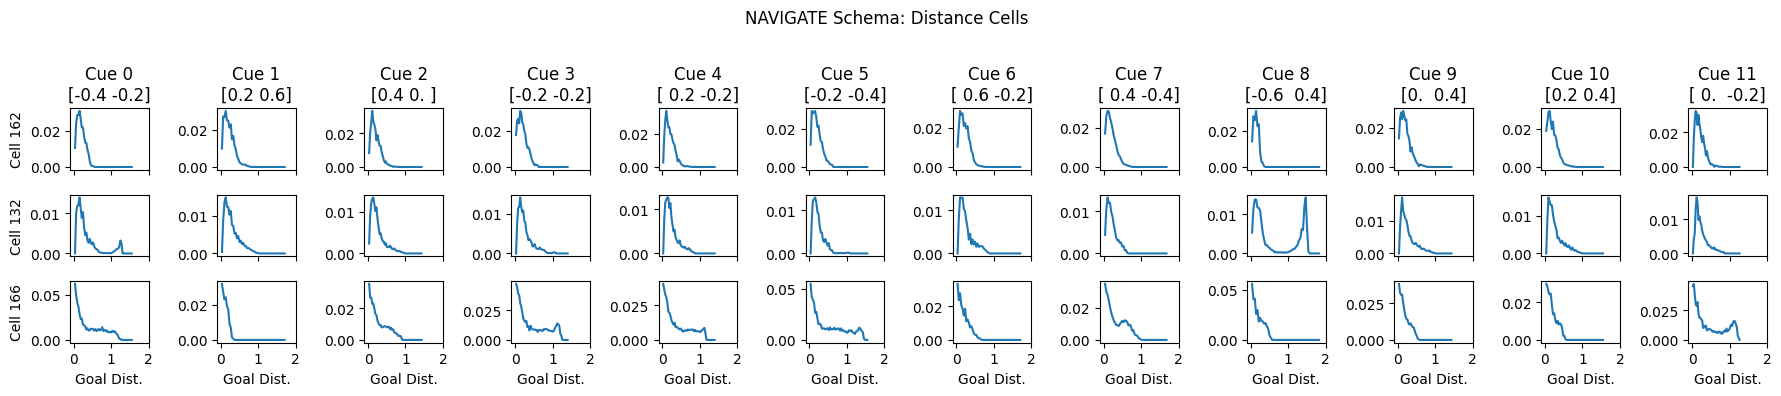

In [20]:
# Plot Distance Cells
plot_distance_cells(hs, goal_distances, distance_cell_idxs, cell_type='NAVIGATE Schema: Distance', bins=n_bins)


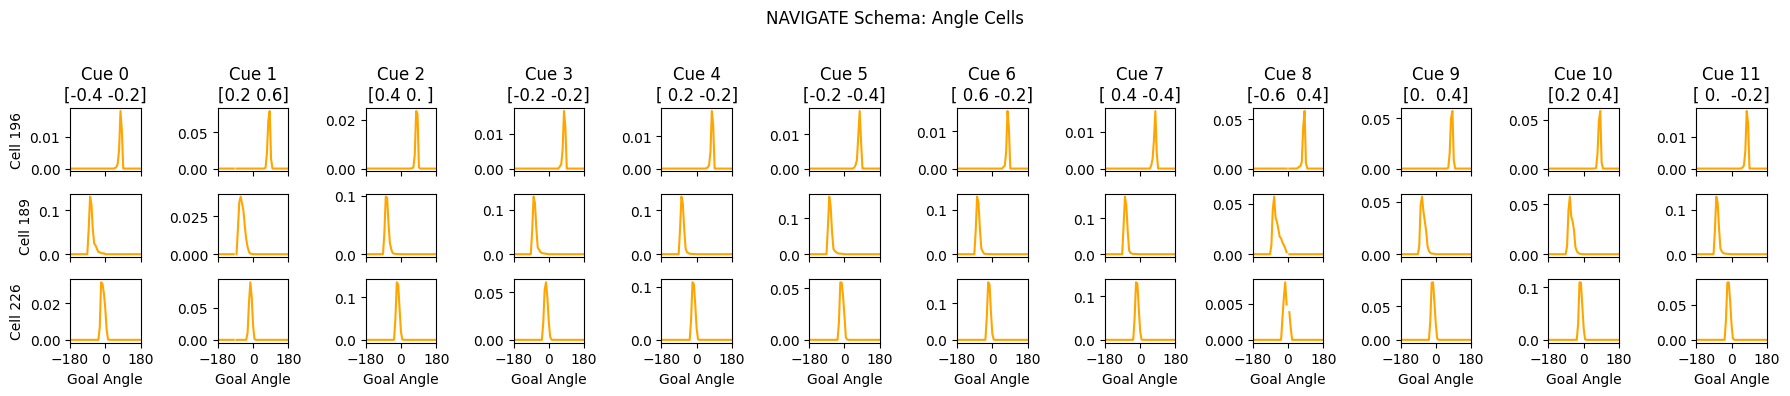

In [21]:

# Plot Angle Cells
plot_angle_cells(hs, goal_angles, angle_cell_idxs, cell_type='NAVIGATE Schema: Angle', bins=n_bins)